<a href="https://colab.research.google.com/github/rrupam/BERT_sentence_classification/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following  [this]( https://towardsdatascience.com/bert-classifier-just-another-pytorch-model-881b3cf05784) blog for sentence classification using a pretrained BERT model, with multiclass, instead of binary. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
% cd drive/My Drive/Colab Notebooks/PTSD/Sentiment_Analysis

/content/drive/My Drive/Colab Notebooks/PTSD/Sentiment_Analysis


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from random import randrange
import torch.nn.functional as F

In [0]:
#DATASET_COLUMNS = ['target','ids','date','flag','user', 'text']
data = pd.read_csv('train.tsv',delimiter='\t',encoding='utf-8', nrows=10000)#, encoding ="ISO-8859-1" , names=DATASET_COLUMNS, nrows=10000)

In [0]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
data['Sentiment'].unique()

array([1, 2, 3, 4, 0])

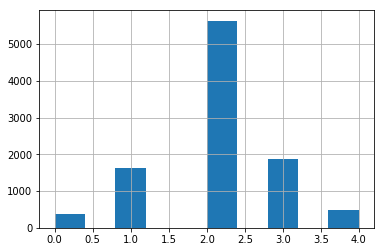

In [0]:
data['Sentiment'].hist()

In [0]:
import sys
package_dir = "../input/ppbert/pytorch-pretrained-bert/pytorch-pretrained-BERT"
sys.path.append(package_dir)

# **Training**

In [12]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 2.7MB/s 
     |████████████████████████████████| 655kB 8.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import torch.utils.data
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import warnings
#import pytorch_pretrained_bert
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
from pytorch_pretrained_bert import BertConfig
from pytorch_pretrained_bert.modeling import BertModel, BertForMaskedLM

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 5)

warnings.filterwarnings(action='once')
device = torch.device('cuda')

100%|██████████| 407873900/407873900 [00:38<00:00, 10628277.61B/s]


In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 917924.04B/s]


In [0]:
from sklearn.model_selection import train_test_split
#sentiment_columns = ['Negative','Somewhat Negative','Neutral','Somewhat Positive', 'Positive']
X = data['Phrase']
y = data['Sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(

In [0]:
X_train = X_train.values.tolist()
X_test = X_test.values.tolist()

y_train = pd.get_dummies(y_train).values.tolist()
y_test = pd.get_dummies(y_test).values.tolist()

Now we create a class to preprocess data that involves tokenizing, truncating and padding.

In [0]:
max_seq_length = 256
class text_dataset(Dataset):
    def __init__(self,x_y_list, transform=None):
        
        self.x_y_list = x_y_list
        self.transform = transform
        
    def __getitem__(self,index):
        
        tokenized_review = tokenizer.tokenize(self.x_y_list[0][index])
        
        if len(tokenized_review) > max_seq_length:
            tokenized_review = tokenized_review[:max_seq_length]
            
        ids_review  = tokenizer.convert_tokens_to_ids(tokenized_review)

        padding = [0] * (max_seq_length - len(ids_review))
        
        ids_review += padding
        
        assert len(ids_review) == max_seq_length
        
        #print("Hello")
        ids_review = torch.tensor(ids_review)
        
        sentiment = self.x_y_list[1][index] # color        
        list_of_labels = [torch.from_numpy(np.array(sentiment))]
        
        
        return ids_review, list_of_labels[0]
    
    def __len__(self):
        return len(self.x_y_list[0])

Preparing and loading the data

In [0]:
batch_size = 16

train_lists = [X_train, y_train]
test_lists = [X_test, y_test]

training_dataset = text_dataset(x_y_list = train_lists )

test_dataset = text_dataset(x_y_list = test_lists )

dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
                   'val':torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                   }
dataset_sizes = {'train':len(train_lists[0]),
                'val':len(test_lists[0])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class BertLayerNorm(nn.Module):
        def __init__(self, hidden_size, eps=1e-12):
            """Construct a layernorm module in the TF style (epsilon inside the square root).
            """
            super(BertLayerNorm, self).__init__()
            self.weight = nn.Parameter(torch.ones(hidden_size))
            self.bias = nn.Parameter(torch.zeros(hidden_size))
            self.variance_epsilon = eps

        def forward(self, x):
            u = x.mean(-1, keepdim=True)
            s = (x - u).pow(2).mean(-1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.variance_epsilon)
            return self.weight * x + self.bias
        

class BertForSequenceClassification(nn.Module):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.
    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary. Items in the batch should begin with the special "CLS" token. (see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller
            than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].
    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].
    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)
    num_labels = 2
    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, num_labels=5):
        super(BertForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        nn.init.xavier_normal_(self.classifier.weight)
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

In [0]:
from pytorch_pretrained_bert import BertConfig

config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

num_labels = 5
model = BertForSequenceClassification(num_labels)

# Convert inputs to PyTorch tensors
#tokens_tensor = torch.tensor([tokenizer.convert_tokens_to_ids(zz)])

#logits = model(tokens_tensor)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    print('starting')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            
            sentiment_corrects = 0
            
            
            # Iterate over data.
            for inputs, sentiment in dataloaders_dict[phase]:
                #print("ok till here")
                #inputs = inputs
                #print(len(inputs),type(inputs),inputs)
                #inputs = torch.from_numpy(np.array(inputs)).to(device) 
                inputs = inputs.to(device) 

                sentiment = sentiment.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
 
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #print(inputs)
                    outputs = model(inputs)

                    outputs = F.softmax(outputs,dim = 1)
                    
                    loss = criterion(outputs, torch.max(sentiment.float(), 1)[1])
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

                
                sentiment_corrects += torch.sum(torch.max(outputs, 1)[1] == torch.max(sentiment, 1)[1])

                
            epoch_loss = running_loss / dataset_sizes[phase]

            
            sentiment_acc = sentiment_corrects.double() / dataset_sizes[phase]

            print('{} total loss: {:.4f} '.format(phase,epoch_loss ))
            print('{} sentiment_acc: {:.4f}'.format(
                phase, sentiment_acc))

            if phase == 'val' and epoch_loss < best_loss:
                print('saving with loss of {}'.format(epoch_loss),
                      'improved over previous {}'.format(best_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'bert_model_test.pth')


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(float(best_loss)))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [0]:
lrlast = .001
lrmain = .00001
optim1 = optim.Adam(
    [
        {"params":model.bert.parameters(),"lr": lrmain},
        {"params":model.classifier.parameters(), "lr": lrlast},
       
   ])

#optim1 = optim.Adam(model.parameters(), lr=0.001)#,momentum=.9)
# Observe that all parameters are being optimized
optimizer_ft = optim1
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [0]:
model.to(device)
model_ft1 = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

starting
Epoch 0/9
----------
train total loss: 1.3417 
train sentiment_acc: 0.5636
val total loss: 1.3438 
val sentiment_acc: 0.5610
saving with loss of 1.3438354759216309 improved over previous 100

Epoch 1/9
----------
train total loss: 1.3407 
train sentiment_acc: 0.5641
val total loss: 1.3438 
val sentiment_acc: 0.5610
saving with loss of 1.343833745956421 improved over previous 1.3438354759216309

Epoch 2/9
----------


KeyboardInterrupt: ignored

# **TESTING**

In [0]:
final_test = pd.read_csv('test.tsv',delimiter='\t',encoding='utf-8')

In [7]:
final_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


Pick out the data and put it in a list

In [0]:
X_final_test = final_test['Phrase']
X_final_test = X_final_test.values.tolist()
#print(X_final_test)

Define a function to preprocess the data

In [0]:
max_seq_length = 256
reviews=[]
def test_dataset(Dataset):
    for i in range(0,len(Dataset)):
      tokenized_review = tokenizer.tokenize(Dataset[i])

      if len(tokenized_review) > max_seq_length:
          tokenized_review = tokenized_review[:max_seq_length]

      ids_review  = tokenizer.convert_tokens_to_ids(tokenized_review)

      padding = [0] * (max_seq_length - len(ids_review))

      ids_review += padding

      assert len(ids_review) == max_seq_length

      #print("Hello")
      reviews.append(ids_review)

    #sentiment = self.x_y_list[1][index] # color        
    #list_of_labels = [torch.from_numpy(np.array(sentiment))]


    return reviews#, list_of_labels[0]

#def __len__(self):
 #   return len(self.x_list)

Call the function to preprocess the data on our list

In [10]:
X_final_test = test_dataset(X_final_test)
#print(X_final_test)
#test_dataset(X_final_test)

NameError: ignored

Define the model and the configuration

In [0]:
from pytorch_pretrained_bert import BertConfig

config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

num_labels = 5
model = BertForSequenceClassification(num_labels)

Load the model, trained on our data.

In [0]:
#from pytorch_pretrained_bert import BertConfig
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 5)
model.load_state_dict(torch.load('bert_model_test.pth'))
device = torch.device('cuda')

Run our test list through the model and write the results to a file called test_preds

In [0]:
model.to(device)
for param in model.parameters():
    param.requires_grad=False
model.eval()
test_preds = np.zeros((len(final_test),5))
tests =  torch.utils.data.TensorDataset(torch.tensor(X_final_test))#,dtype=torch.long)) 
#tests =  torch.utils.data.DataLoader(X_final_test, batch_size=16, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(tests, batch_size=16, shuffle=False)

#tk0 = tqdm_notebook(test_loader)

for i,(x_batch,)  in enumerate(test_loader):
    t_preds = model(x_batch.to(device), attention_mask=(x_batch>0).to(device), labels=None)
    test_preds[i*16:(i+1)*16]=t_preds[:,0:5].detach().cpu().squeeze().numpy()

In [0]:
t_p = pd.DataFrame(test_preds)

In [0]:
t_p.head()

,0,1,2,3,4
0,-2.643804,-1.892407,3.386405,-2.001749,-3.506268
1,-1.006383,-0.785386,1.779258,-0.790580,-0.163048
2,-2.584310,-1.501119,3.794366,-2.792164,-2.499760
3,-2.001685,-1.462754,2.705199,-1.084235,-1.727064
4,-2.145345,-1.398572,2.399182,-0.931489,-1.999005


Define a softmax function for our predictions (so we get a probability distribution)

In [0]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [0]:
test_preds1 = t_p.apply(lambda x:softmax(x), axis=1)


In [0]:
pd.DataFrame(test_preds1).to_csv("test_preds1.csv")